In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#from tensorflow.data.Dataset import load
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd

import os
from file_helpers import unpickle_from_file

2024-03-21 02:52:08.450676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_labels_sorted = unpickle_from_file('../data/processed_data/train_labels_sorted.bin')

In [3]:
#Read training data
batch_size = 75
img_height = 227
img_width = 227

train_ds = tf.keras.utils.image_dataset_from_directory(
  '../data/processed_data/training_images',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
labels = train_labels_sorted)

Found 51957 files belonging to 8 classes.
Using 44164 files for training.


2024-03-21 02:52:12.918795: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
#Read validation data

val_ds = tf.keras.utils.image_dataset_from_directory(
  '../data/processed_data/training_images',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
labels = train_labels_sorted)

Found 51957 files belonging to 8 classes.
Using 7793 files for validation.


In [5]:
#Try to keep things in memory for performance reasons
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
def model_builder():
	img_height = 227
	mg_width = 227
	
	num_classes = 8
	
	model_layers = [
		layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
		layers.Conv2D(16, 3, padding='same', activation='relu'),
		layers.MaxPooling2D(),
		layers.Conv2D(32, 3, padding='same', activation='relu'),
		layers.MaxPooling2D(),
		layers.Conv2D(64, 3, padding='same', activation='relu'),
		layers.MaxPooling2D(),
		layers.Dropout(0.2),
		layers.Flatten(),
		layers.Dense(256, activation='relu'),
		layers.Dense(256, activation='relu'),
		layers.Dense(256, activation='relu'),
		layers.Dense(num_classes)]
	
	model = Sequential(model_layers)
	
	model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
			loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
			metrics=['accuracy'])
	return model


In [7]:
epochs= 5

#Silence debug messages for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

model_1 = model_builder()

history = model_1.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/5


2024-03-21 02:52:20.144057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [44164]
	 [[{{node Placeholder/_4}}]]
2024-03-21 02:52:20.144681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [44164]
	 [[{{node Placeholder/_4}}]]
2024-03-21 02:52:31.862630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 566 of 1000
2024-03-21 02:52:32.150273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


589/589 [==============================] - ETA: 0s - loss: 1.7588 - accuracy: 0.8123

2024-03-21 03:28:18.159053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7793]
	 [[{{node Placeholder/_0}}]]
2024-03-21 03:28:18.160569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7793]
	 [[{{node Placeholder/_0}}]]


589/589 [==============================] - 2189s 4s/step - loss: 1.7588 - accuracy: 0.8123 - val_loss: 0.7886 - val_accuracy: 0.8182
Epoch 2/5
589/589 [==============================] - 2202s 4s/step - loss: 0.7989 - accuracy: 0.8133 - val_loss: 0.7861 - val_accuracy: 0.8182
Epoch 3/5
589/589 [==============================] - 2234s 4s/step - loss: 0.7974 - accuracy: 0.8133 - val_loss: 0.7857 - val_accuracy: 0.8182
Epoch 4/5
589/589 [==============================] - 2244s 4s/step - loss: 0.7968 - accuracy: 0.8133 - val_loss: 0.7844 - val_accuracy: 0.8182
Epoch 5/5
589/589 [==============================] - 2220s 4s/step - loss: 0.7970 - accuracy: 0.8133 - val_loss: 0.7843 - val_accuracy: 0.8182


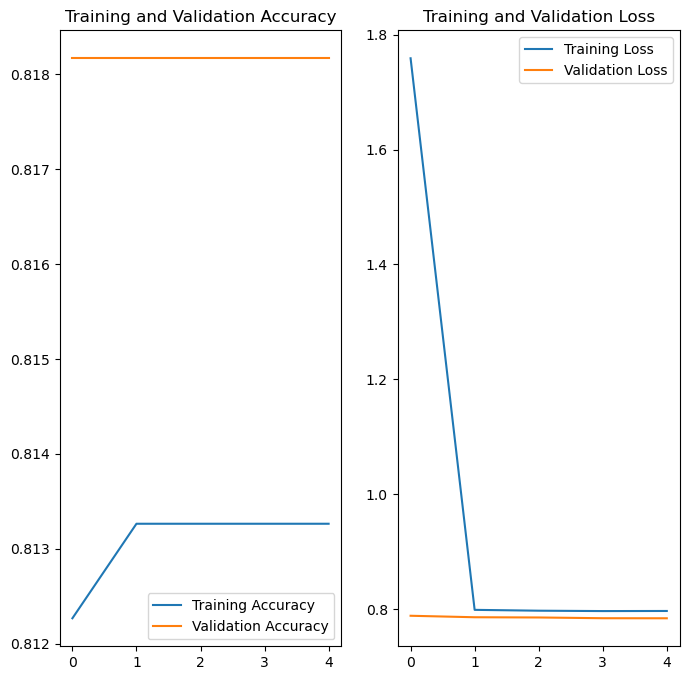

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
#Read training data
batch_size = 85
img_height = 227
img_width = 227

train_ds = tf.keras.utils.image_dataset_from_directory(
  '../data/processed_data/training_images',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
labels = train_labels_sorted)

Found 51957 files belonging to 8 classes.
Using 44164 files for training.


In [10]:
#Read validation data

val_ds = tf.keras.utils.image_dataset_from_directory(
  '../data/processed_data/training_images',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
labels = train_labels_sorted)

Found 51957 files belonging to 8 classes.
Using 7793 files for validation.


In [12]:
epochs=10

#Silence debug messages for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

model_2 = model_builder()
history_2 = model_2.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/10


2024-03-21 05:58:35.858954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [44164]
	 [[{{node Placeholder/_4}}]]
2024-03-21 05:58:35.859480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [44164]
	 [[{{node Placeholder/_4}}]]


520/520 [==============================] - ETA: 0s - loss: 1.5584 - accuracy: 0.8093

2024-03-21 06:34:09.933817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7793]
	 [[{{node Placeholder/_4}}]]
2024-03-21 06:34:09.935329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7793]
	 [[{{node Placeholder/_4}}]]


520/520 [==============================] - 2167s 4s/step - loss: 1.5584 - accuracy: 0.8093 - val_loss: 0.7908 - val_accuracy: 0.8160
Epoch 2/10
520/520 [==============================] - 2040s 4s/step - loss: 0.7987 - accuracy: 0.8127 - val_loss: 0.7919 - val_accuracy: 0.8160
Epoch 3/10
520/520 [==============================] - 2133s 4s/step - loss: 0.7986 - accuracy: 0.8127 - val_loss: 0.7911 - val_accuracy: 0.8160
Epoch 4/10
520/520 [==============================] - 2031s 4s/step - loss: 0.7985 - accuracy: 0.8127 - val_loss: 0.7905 - val_accuracy: 0.8160
Epoch 5/10
520/520 [==============================] - 2082s 4s/step - loss: 0.7987 - accuracy: 0.8127 - val_loss: 0.7904 - val_accuracy: 0.8160
Epoch 6/10
520/520 [==============================] - 2107s 4s/step - loss: 0.7987 - accuracy: 0.8127 - val_loss: 0.7905 - val_accuracy: 0.8160
Epoch 7/10
520/520 [==============================] - 2072s 4s/step - loss: 0.7984 - accuracy: 0.8127 - val_loss: 0.7903 - val_accuracy: 0.8160
Epo

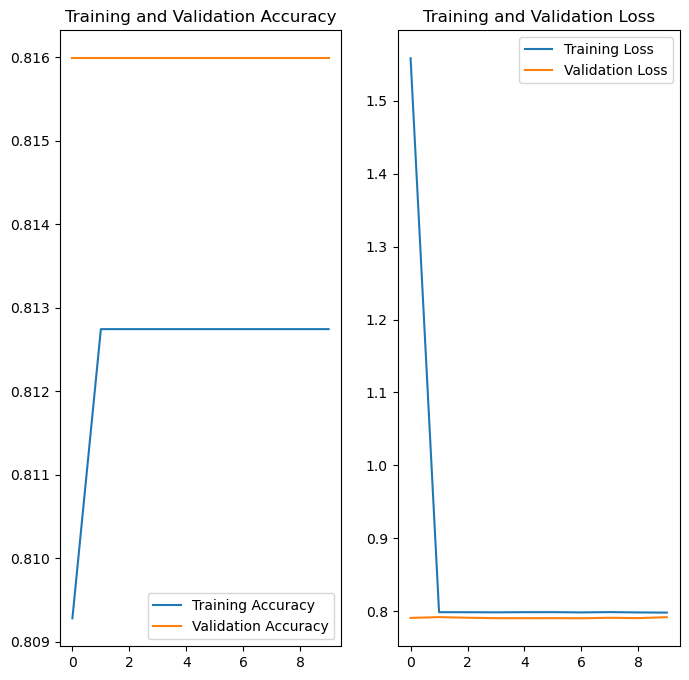

In [13]:
acc =history_2.history['accuracy']
val_acc =history_2.history['val_accuracy']

loss =history_2.history['loss']
val_loss =history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
#Read training data
batch_size = 65
img_height = 227
img_width = 227

train_ds = tf.keras.utils.image_dataset_from_directory(
  '../data/processed_data/training_images',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
labels = train_labels_sorted)

Found 51957 files belonging to 8 classes.
Using 44164 files for training.


In [15]:
#Read validation data

val_ds = tf.keras.utils.image_dataset_from_directory(
  '../data/processed_data/training_images',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
labels = train_labels_sorted)

Found 51957 files belonging to 8 classes.
Using 7793 files for validation.


In [16]:
epochs=5

#Silence debug messages for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

model_3 = model_builder()
history_3 = model_3.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/5


2024-03-21 11:49:16.840534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [44164]
	 [[{{node Placeholder/_4}}]]
2024-03-21 11:49:16.841053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [44164]
	 [[{{node Placeholder/_4}}]]


680/680 [==============================] - ETA: 0s - loss: 1.0779 - accuracy: 0.8138

2024-03-21 12:26:08.221758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7793]
	 [[{{node Placeholder/_4}}]]
2024-03-21 12:26:08.222690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7793]
	 [[{{node Placeholder/_4}}]]


680/680 [==============================] - 2244s 3s/step - loss: 1.0779 - accuracy: 0.8138 - val_loss: 0.7911 - val_accuracy: 0.8159
Epoch 2/5
680/680 [==============================] - 2310s 3s/step - loss: 0.7962 - accuracy: 0.8143 - val_loss: 0.7877 - val_accuracy: 0.8159
Epoch 3/5
680/680 [==============================] - 2324s 3s/step - loss: 0.7954 - accuracy: 0.8143 - val_loss: 0.7888 - val_accuracy: 0.8159
Epoch 4/5
680/680 [==============================] - 2340s 3s/step - loss: 0.7952 - accuracy: 0.8143 - val_loss: 0.7880 - val_accuracy: 0.8159
Epoch 5/5
680/680 [==============================] - 2226s 3s/step - loss: 0.7947 - accuracy: 0.8143 - val_loss: 0.7860 - val_accuracy: 0.8159


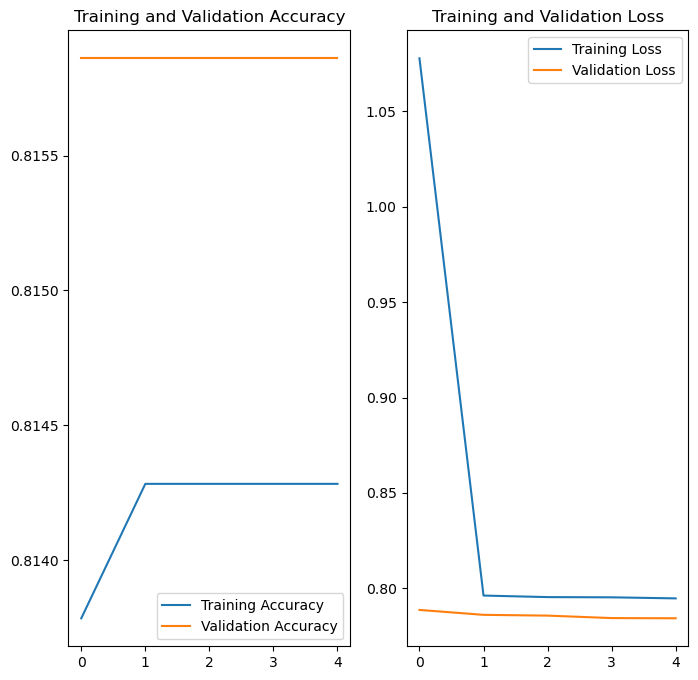

In [17]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()